
[Static RF]  thr=0.50
Acc=0.996  Prec=0.995  Rec=0.998  F1=0.997  ROC-AUC=1.000
Confusion matrix [tn fp; fn tp]:
 [[6740   40]
 [  17 8825]]


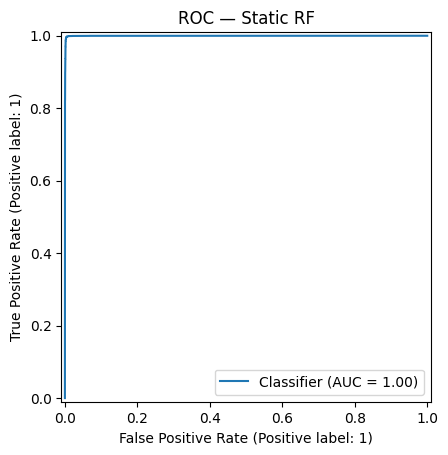

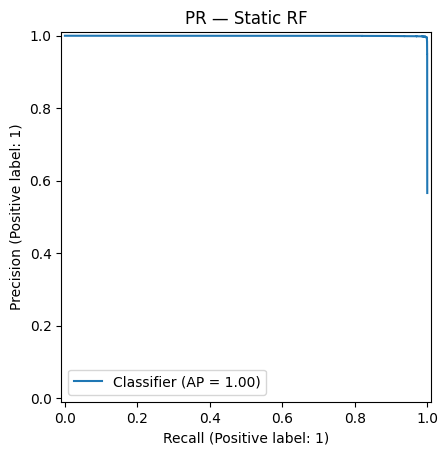

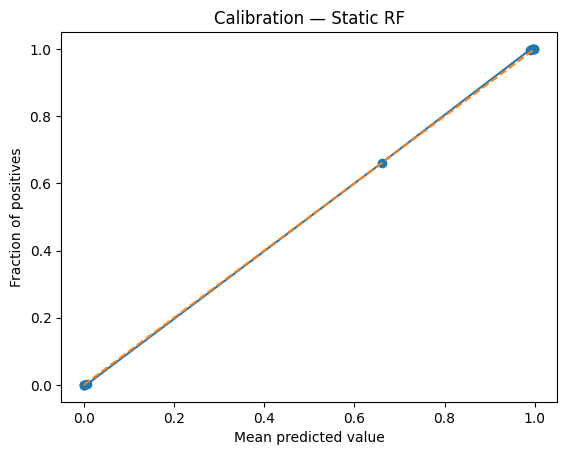


[Static XGB (tuned)]  thr=0.50
Acc=0.997  Prec=0.997  Rec=0.998  F1=0.997  ROC-AUC=1.000
Confusion matrix [tn fp; fn tp]:
 [[6754   26]
 [  19 8823]]


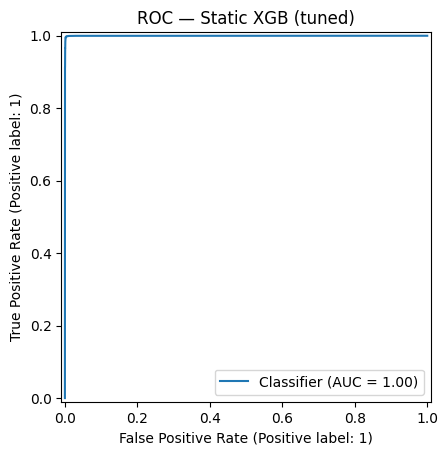

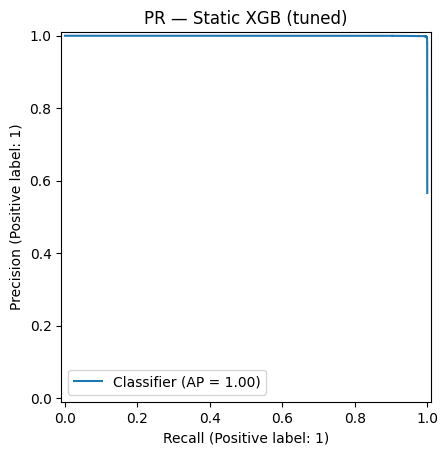

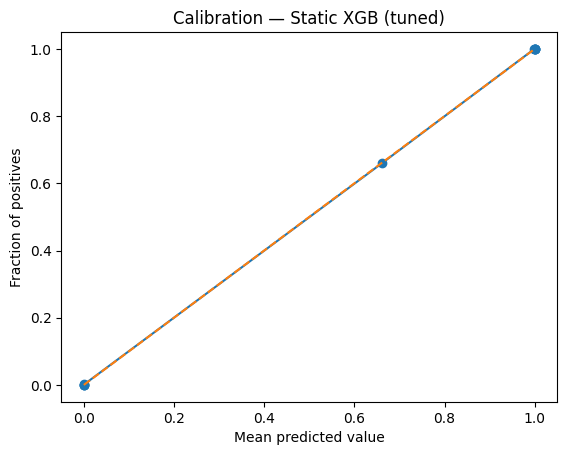

ValueError: invalid literal for int() with base 10: 'SS'

In [4]:
# 04_final_evaluation.py  (can also be a notebook)
import json, joblib, os, io, warnings
import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ------------------------------
# Paths (adjust if needed)
# ------------------------------
ROOT = ".."  # run from notebooks/; ROOT points to project root
MODELS = os.path.join(ROOT, "models")
OPT = os.path.join(MODELS, "optimized")
RAW = os.path.join(ROOT, "datasets")
PROC = os.path.join(ROOT, "data_processed")

# Static data (must have label)
STATIC_CSV = os.path.join(RAW, "static", "ransomware_detection.csv")
# Behavioral data (must have label)
BEHAV_CSV = os.path.join(RAW, "behavioral", "ugransom.csv")

# Models (optimized)
STATIC_XGB = os.path.join(OPT, "static_xgb_tuned.joblib")
STATIC_XGB_FEATS = os.path.join(OPT, "static_xgb_feature_names.joblib")
STATIC_XGB_THR = os.path.join(OPT, "static_xgb_threshold.json")

STATIC_RF  = os.path.join(OPT, "static_rf_tuned.joblib") if os.path.exists(os.path.join(OPT,"static_rf_tuned.joblib")) else os.path.join(MODELS,"models","static_rf.joblib")
STATIC_RF_FEATS = os.path.join(OPT, "static_rf_feature_names.joblib") if os.path.exists(os.path.join(OPT,"static_rf_feature_names.joblib")) else os.path.join(MODELS,"models","static_feature_names.joblib")
STATIC_RF_THR = os.path.join(OPT, "static_rf_threshold.json") if os.path.exists(os.path.join(OPT,"static_rf_threshold.json")) else os.path.join(MODELS,"models","static_rf_threshold.json")

BEHAV_CAT = os.path.join(OPT, "behav_catboost_tuned.cbm")
BEHAV_FEATS = os.path.join(OPT, "behav_feature_names.json")
BEHAV_THR = os.path.join(OPT, "behav_threshold.json")

# ------------------------------
# Helpers
# ------------------------------
def load_feature_names(path):
    if path.endswith(".joblib"):
        return joblib.load(path)
    return json.load(open(path))

def ensure_columns(X, feature_names):
    # create missing columns with zeros; maintain order
    for c in feature_names:
        if c not in X.columns:
            X[c] = 0.0
    return X[feature_names]

def print_scores(name, y_true, proba, thr=0.5):
    y_pred = (proba >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, proba)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n[{name}]  thr={thr:.2f}")
    print(f"Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  ROC-AUC={roc:.3f}")
    print("Confusion matrix [tn fp; fn tp]:\n", cm)
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, roc=roc, cm=cm)

def plot_curves(name, y_true, proba):
    RocCurveDisplay.from_predictions(y_true, proba)
    plt.title(f"ROC — {name}")
    plt.show()
    PrecisionRecallDisplay.from_predictions(y_true, proba)
    plt.title(f"PR — {name}")
    plt.show()
    frac_pos, mean_pred = calibration_curve(y_true, proba, n_bins=10, strategy="quantile")
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0,1],[0,1], "--")
    plt.title(f"Calibration — {name}")
    plt.xlabel("Mean predicted value"); plt.ylabel("Fraction of positives"); plt.show()

def load_json_or_default(path, default=0.5):
    try:
        return float(json.load(open(path)).get("threshold", default))
    except Exception:
        return default

# ------------------------------
# Load static dataset
# Expect a binary label column: either 'Benign' (1=benign) or something like 'is_malware'.
# We'll create y = 1 for malicious.
# ------------------------------
static_df = pd.read_csv(STATIC_CSV)
# Try to infer label:
if "Benign" in static_df.columns:
    y_static = 1 - static_df["Benign"].astype(int)   # Benign=1 => malware=0, so invert
elif "is_malware" in static_df.columns:
    y_static = static_df["is_malware"].astype(int)
else:
    raise ValueError("Static CSV must contain either 'Benign' or 'is_malware' label.")
X_static = static_df.drop(columns=[c for c in ["Benign","is_malware"] if c in static_df.columns])

# Split once to avoid leakage; use same seed for comparability
Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(X_static, y_static, test_size=0.25, random_state=42, stratify=y_static)

# ------------------------------
# Evaluate STATIC: RandomForest
# ------------------------------
rf_feats = load_feature_names(STATIC_RF_FEATS)
Xs_te_rf = ensure_columns(Xs_te.copy(), rf_feats)
rf = joblib.load(STATIC_RF)
# model may be plain estimator or pipeline; use predict_proba
rf_proba = rf.predict_proba(Xs_te_rf)[:,1]
rf_thr = load_json_or_default(STATIC_RF_THR, 0.5)
rf_metrics = print_scores("Static RF", ys_te.values, rf_proba, thr=rf_thr)
plot_curves("Static RF", ys_te.values, rf_proba)

# ------------------------------
# Evaluate STATIC: XGBoost (tuned)
# ------------------------------
xgb_feats = load_feature_names(STATIC_XGB_FEATS)
Xs_te_xgb = ensure_columns(Xs_te.copy(), xgb_feats)
xgb = joblib.load(STATIC_XGB)   # pipeline or model
xgb_proba = xgb.predict_proba(Xs_te_xgb)[:,1]
xgb_thr = load_json_or_default(STATIC_XGB_THR, 0.5)
xgb_metrics = print_scores("Static XGB (tuned)", ys_te.values, xgb_proba, thr=xgb_thr)
plot_curves("Static XGB (tuned)", ys_te.values, xgb_proba)

# ------------------------------
# Load behavioral dataset (needs binary label)
# Try to infer malware positive based on 'Family' column if present (WannaCry etc.)
# Otherwise expect 'Prediction' or a provided 'label' column; adjust as needed.
# ------------------------------
behav_df = pd.read_csv(BEHAV_CSV)
if "Prediction" in behav_df.columns:
    y_behav = behav_df["Prediction"].astype(int)
elif "Family" in behav_df.columns:
    # Example: label 1 if Family == "WannaCry", else 0 (adjust to your target label)
    y_behav = (behav_df["Family"].astype(str).str.lower().str.contains("wannacry")).astype(int)
elif "label" in behav_df.columns:
    y_behav = behav_df["label"].astype(int)
else:
    raise ValueError("Behavior CSV needs a binary label column (Prediction/label) or derive from 'Family'.")

X_behav = behav_df.drop(columns=[c for c in ["Prediction","label"] if c in behav_df.columns], errors="ignore")

Xb_tr, Xb_te, yb_tr, yb_te = train_test_split(X_behav, y_behav, test_size=0.25, random_state=42, stratify=y_behav)

# ------------------------------
# Evaluate BEHAV: CatBoost (tuned)
# ------------------------------
from catboost import CatBoostClassifier
behav_feats = load_feature_names(BEHAV_FEATS)
Xb_te_cb = ensure_columns(Xb_te.copy(), behav_feats)
cb = CatBoostClassifier()
cb.load_model(BEHAV_CAT)  # loads tuned model
cb_proba = cb.predict_proba(Xb_te_cb)[:,1]
cb_thr = load_json_or_default(BEHAV_THR, 0.5)
cb_metrics = print_scores("Behavior CatBoost (tuned)", yb_te.values, cb_proba, thr=cb_thr)
plot_curves("Behavior CatBoost (tuned)", yb_te.values, cb_proba)

# ------------------------------
# HYBRID B: Simple weighted fusion when both sets exist for same sample
# For a clean demo, we can't align different datasets 1:1. In production,
# you'd compute BOTH static+behavior features for the SAME sample.
# Here we simulate fusion by matching sizes or taking min length.
# ------------------------------
n = min(len(ys_te), len(yb_te))
hyb_y = ys_te.values[:n]  # assuming same positive definition (malicious=1)
w_static, w_behav = 0.6, 0.4
hyb_proba = w_static * xgb_proba[:n] + w_behav * cb_proba[:n]

# If you have a dedicated fusion threshold, load it; else pick 0.5 or tune below:
fusion_thr = 0.5
hyb_metrics = print_scores("Hybrid (0.6*XGB + 0.4*CatBoost)", hyb_y, hyb_proba, thr=fusion_thr)
plot_curves("Hybrid (0.6*XGB + 0.4*CatBoost)", hyb_y, hyb_proba)

# ------------------------------
# OPTIONAL: tune threshold to hit a target FPR or maximize F1
# ------------------------------
def find_best_threshold(y_true, proba, metric="f1"):
    thresholds = np.linspace(0.05, 0.95, 19)
    best_thr, best_val = 0.5, -1
    for t in thresholds:
        y_pred = (proba >= t).astype(int)
        if metric == "f1":
            val = f1_score(y_true, y_pred, zero_division=0)
        elif metric == "youden":
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            tpr = tp / (tp + fn + 1e-9)
            fpr = fp / (fp + tn + 1e-9)
            val = tpr - fpr
        else:
            val = 0
        if val > best_val:
            best_val, best_thr = val, t
    return best_thr, best_val

best_thr_hyb, val = find_best_threshold(hyb_y, hyb_proba, metric="f1")
print(f"\n[Hybrid] best F1 threshold ~ {best_thr_hyb:.2f}, F1={val:.3f}")


In [6]:
# robust_diagnostics_static.py
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# -------- 1) Find the static CSV robustly
CAND_NAME = "ransomware_detection.csv"
start = Path.cwd()
cands = list(start.rglob(CAND_NAME))
if not cands:
    # also try one level up (typical if you're inside notebooks/)
    cands = list(start.parent.rglob(CAND_NAME))
assert cands, f"Could not find {CAND_NAME} from {start}"
CSV = str(cands[0])
print(f"Using CSV: {CSV}")

df = pd.read_csv(CSV)
print("Rows x Cols:", df.shape)
print("Columns:", list(df.columns))

# -------- 2) Potential label/leak columns
suspect = [c for c in df.columns if any(k in c.lower() for k in
            ["label","malware","benign","prediction","target","class"])]
print("Potential label/leak columns:", suspect)

# -------- 3) Duplicates
dups_all = df.duplicated().sum()
print("Exact duplicate rows:", dups_all)

# -------- 4) ID-like columns that could leak
id_cols = [c for c in df.columns if c.lower() in ["md5hash","filename","sha256","hash","file","filepath"]]
for c in id_cols:
    print(f"{c}: unique={df[c].nunique()} / total={len(df)}")

# -------- 5) Correlation to the label
label_col = "Benign" if "Benign" in df.columns else ("is_malware" if "is_malware" in df.columns else None)
assert label_col is not None, "Need a label column."
y = (1 - df["Benign"].astype(int)) if label_col=="Benign" else df[label_col].astype(int)
X = df.drop(columns=[label_col])

num = X.select_dtypes(include=[np.number]).copy()
corr = num.corrwith(y)
print("Top 15 abs correlations:\n", corr.abs().sort_values(ascending=False).head(15))

# -------- 6) Shuffled-label sanity (should be ~0.5 AUC)
y_shuf = y.sample(frac=1.0, random_state=123).reset_index(drop=True)
X_s, X_t, y_s, y_t = train_test_split(num, y_shuf, test_size=0.25, random_state=42, stratify=y_shuf)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_s, y_s)
auc = roc_auc_score(y_t, rf.predict_proba(X_t)[:,1])
print("Shuffled-label AUC (should be ~0.5):", round(auc,3))

# -------- 7) GroupKFold by file/hash to prevent leakage (if such a column exists)
group_key = None
for c in ["md5Hash","sha256","FileName","filename","hash","file","filepath"]:
    if c in df.columns:
        group_key = c; break

if group_key:
    print("Using GroupKFold grouped by:", group_key)
    gkf = GroupKFold(n_splits=5)
    aucs=[]
    for tr, te in gkf.split(num, y, groups=df[group_key]):
        rf = RandomForestClassifier(n_estimators=200, random_state=42)
        rf.fit(num.iloc[tr], y.iloc[tr])
        proba = rf.predict_proba(num.iloc[te])[:,1]
        aucs.append(roc_auc_score(y.iloc[te], proba))
    print("GroupKFold AUCs:", [round(a,3) for a in aucs], "mean:", round(np.mean(aucs),3))
else:
    print("No obvious grouping column for GroupKFold; keep regular split but beware duplicates.")


Using CSV: c:\Users\richa\OneDrive\Documents\FYP2\datasets\static\ransomware_detection.csv
Rows x Cols: (62485, 18)
Columns: ['FileName', 'md5Hash', 'Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion', 'MajorOSVersion', 'ExportRVA', 'ExportSize', 'IatVRA', 'MajorLinkerVersion', 'MinorLinkerVersion', 'NumberOfSections', 'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 'BitcoinAddresses', 'Benign']
Potential label/leak columns: ['Benign']
Exact duplicate rows: 0
FileName: unique=62485 / total=62485
md5Hash: unique=62485 / total=62485
Top 15 abs correlations:
 Machine               0.549434
MajorOSVersion        0.398076
MajorLinkerVersion    0.296925
SizeOfStackReserve    0.282151
DllCharacteristics    0.261118
MinorLinkerVersion    0.111294
IatVRA                0.084622
DebugRVA              0.072781
BitcoinAddresses      0.054824
MajorImageVersion     0.049603
NumberOfSections      0.020433
ExportRVA             0.012547
ExportSize            0.012457
DebugSize         

In [7]:
from pathlib import Path
import pandas as pd

# find UGRansom robustly
cands = list(Path.cwd().rglob("ugransom.csv")) or list(Path.cwd().parent.rglob("ugransom.csv"))
assert cands, "Could not find ugransom.csv"
CSV = str(cands[0]); print("Behavior CSV:", CSV)

df = pd.read_csv(CSV)
print("Columns:", list(df.columns))

# Peek unique values to decide mapping
for c in ["Prediction","Family","Flag","Threats"]:
    if c in df.columns:
        vals = df[c].astype(str).unique()[:20]
        print(f"Sample unique values for {c}:", vals)

# EXAMPLE mapping — EDIT once you see the codes/semantics
if "Prediction" in df.columns and not pd.api.types.is_numeric_dtype(df["Prediction"]):
    code_map = {"AA":1, "SS":0}  # <-- replace with your real mapping
    if set(df["Prediction"].astype(str).unique()) <= set(code_map.keys()):
        df["label"] = df["Prediction"].astype(str).map(code_map).astype(int)
        print("Mapped Prediction → label via code_map.")
    else:
        # fallback: use Family keywords
        fam = df.get("Family", pd.Series([""]*len(df))).astype(str).str.lower()
        df["label"] = fam.str.contains("ransom|wannacry|locker|crypt|ryuk|maze|revil|locky").astype(int)
        print("Used Family keyword rule → label.")
elif "Prediction" in df.columns:
    df["label"] = df["Prediction"].astype(int)
else:
    # as last resort
    fam = df.get("Family", pd.Series([""]*len(df))).astype(str).str.lower()
    df["label"] = fam.str_contains("ransom|wannacry|locker|crypt|ryuk|maze|revil|locky").astype(int)

print("Positive rate (1=malicious):", df["label"].mean())
# Save a clean copy for CatBoost eval if you want
df.to_csv(CSV.replace(".csv","_with_label.csv"), index=False)
print("Saved:", CSV.replace(".csv","_with_label.csv"))


Behavior CSV: c:\Users\richa\OneDrive\Documents\FYP2\datasets\behavioral\ugransom.csv
Columns: ['Time', 'Protcol', 'Flag', 'Family', 'Clusters', 'SeddAddress', 'ExpAddress', 'BTC', 'USD', 'Netflow_Bytes', 'IPaddress', 'Threats', 'Port', 'Prediction']
Sample unique values for Prediction: ['SS' 'A' 'S']
Sample unique values for Family: ['WannaCry' 'Locky' 'TowerWeb' 'CryptXXX' 'Cryptohitman' 'CryptoLocker'
 'NoobCrypt' 'DMALocker' 'Globev3' 'CryptoLocker2015' 'Flyper' 'SamSam'
 'Globe' 'EDA2' 'JigSaw' 'APT' 'Razy']
Sample unique values for Flag: ['A' 'APSF' 'APS' 'ARF' 'AP' 'R' 'AF' 'APRSF' 'ASF']
Sample unique values for Threats: ['Bonet' 'DoS' 'Spam' 'Blacklist' 'SSH' 'UDP Scan' 'Scan' 'NerisBonet'
 'Port Scanning']
Used Family keyword rule → label.
Positive rate (1=malicious): 0.45749884261588936
Saved: c:\Users\richa\OneDrive\Documents\FYP2\datasets\behavioral\ugransom_with_label.csv
